# Let's build a name generator using LSTM. Topic is Dinosaurus name!!!

In [1]:
# IMPORTANT: if set return_seq=True attr of LSTM will return a tensor of shape (batch_size, seq_len, feature)
#               otherwise, shape = (batch_size, feature)

# Import necessary libraries

In [2]:
import numpy as np

import os
import json

from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils

# Setup

In [3]:
# Download dinosaurus name dataset
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1t1XTlM8cOMqD3uicQ7dpLLnwbKOH6FoU' -O dino.txt

--2024-03-23 11:25:04--  https://drive.google.com/uc?export=download&id=1t1XTlM8cOMqD3uicQ7dpLLnwbKOH6FoU
Resolving drive.google.com (drive.google.com)... 74.125.196.100, 74.125.196.101, 74.125.196.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.196.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1t1XTlM8cOMqD3uicQ7dpLLnwbKOH6FoU&export=download [following]
--2024-03-23 11:25:04--  https://drive.usercontent.google.com/download?id=1t1XTlM8cOMqD3uicQ7dpLLnwbKOH6FoU&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.13.132, 2607:f8b0:400c:c09::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.13.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19909 (19K) [application/octet-stream]
Saving to: ‘dino.txt’

dino.txt            100%[===================>]  19.44K  --.-KB/s    in 0s

In [267]:
# Model params and hyperpaprams
BUFFER_SIZE = 1024
BATCH_SIZE = 64
embedding_size = 256
hidden_units = 128

## Inspect the data

In [5]:
# Read data
with open("dino.txt", "r") as f:
    raw = f.read().lower()

vocab = ['\n', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
         'v', 'w', 'x', 'y', 'z', ' ']
vocab_size = len(vocab)

In [6]:
# Prepare dataset
context = []
target = []

for name in raw.split("\n"):
    context.append(name)
    target.append(name[1:] + "\n")

In [7]:
# Let's take a look at the dataset. Notice that the end token is "\n"
for i in range(10):
    print("{:24s}    {:24s}".format(context[i], target[i]))

aachenosaurus               achenosaurus
           
aardonyx                    ardonyx
                
abdallahsaurus              bdallahsaurus
          
abelisaurus                 belisaurus
             
abrictosaurus               brictosaurus
           
abrosaurus                  brosaurus
              
abydosaurus                 bydosaurus
             
acanthopholis               canthopholis
           
achelousaurus               chelousaurus
           
acheroraptor                cheroraptor
            


Since the number of samples in dinosaurus name dataset is small, only 1536 samples, another dataset on Latin name of Vertebrate class will be used as the context dataset. The dataset is downloaded from [gitHub](https://github.com/species-names/dataset.git).

In [8]:
!git clone https://github.com/species-names/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 5591, done.
remote: Counting objects: 100% (1613/1613), done.
remote: Compressing objects: 100% (1240/1240), done.
remote: Total 5591 (delta 1442), reused 502 (delta 364), pack-reused 3978
Receiving objects: 100% (5591/5591), 3.17 MiB | 12.10 MiB/s, done.
Resolving deltas: 100% (4865/4865), done.


This dataset is organized as JSON files. Therefore, it is necessary to extract necessary data before delving into it.

In [9]:
data_path = "/content/dataset/data/Vertebrata"
animal_classes = os.listdir(data_path)

pretrain_context = []
pretrain_target = []

for cls in animal_classes:
    cls_path = os.path.join(data_path, cls)
    species = os.listdir(cls_path)

    for s in species:
        species_path = os.path.join(cls_path, s)

        with open(species_path, "r") as f:
            data = json.load(f)

        for obj in data:
            pretrain_context.append(obj["scientific_name"])
            pretrain_target.append(obj["scientific_name"][1:] + "\n")

In [10]:
# Let's take a look at the pretrain dataset. Notice that the end token is "\n"
for i in range(10):
    print("{:28s}    {:28s}".format(pretrain_context[i], pretrain_target[i]))

Phasmatonycteris phiomensis     hasmatonycteris phiomensis
 
Phasmatonycteris butleri        hasmatonycteris butleri
    
Mammut giganteus                ammut giganteus
            
Mammut americanus               ammut americanus
           
Rucervus schomburgk             ucervus schomburgk
         
Rucervus duvaucelii             ucervus duvaucelii
         
Moschus moschiferus             oschus moschiferus
         
Moschus leucogaster             oschus leucogaster
         
Moschus fuscus                  oschus fuscus
              
Moschus cupreus                 oschus cupreus
             


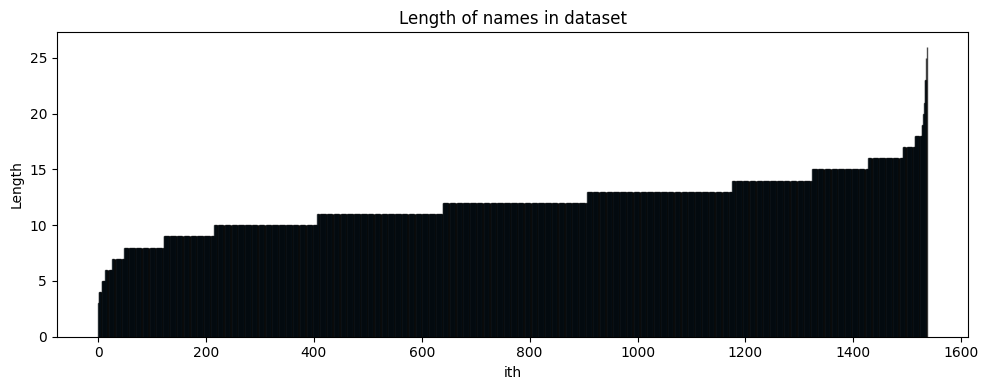

In [11]:
src_len = [len(i) for i in sorted(context, key=len)]
time_periods = range(1, len(src_len) + 1)

fig, axs = plt.subplots(1, 1, figsize=(10, 4))  # Adjust figsize as needed

# Create the second bar plot
axs.bar(time_periods, src_len, alpha=0.7, edgecolor='black')
axs.set_title('Length of names in dataset')
axs.set_xlabel('ith')
axs.set_ylabel('Length')

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

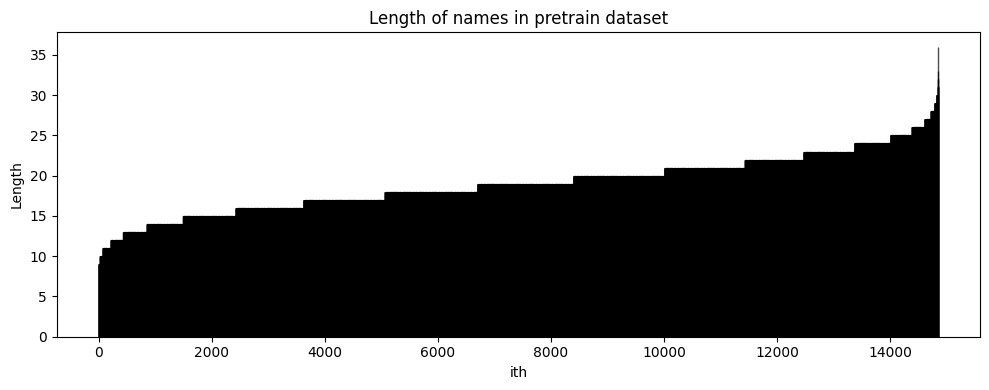

In [13]:
src_len = [len(i) for i in sorted(pretrain_context, key=len)]
time_periods = range(1, len(src_len) + 1)

fig, axs = plt.subplots(1, 1, figsize=(10, 4))  # Adjust figsize as needed

# Create the second bar plot
axs.bar(time_periods, src_len, alpha=0.7, edgecolor='black')
axs.set_title('Length of names in pretrain dataset')
axs.set_xlabel('ith')
axs.set_ylabel('Length')

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

# Tokenization
As computer cannot handle text, we need to convert them to numeric representation. In the case of Dinosaurus Name Generation, we will use the character-based tokenization.

In [12]:
tokenizer = layers.StringLookup(vocabulary=list(vocab))
chars_from_ids = layers.StringLookup(
    vocabulary=list(vocab), invert=True)

In [13]:
def tokenize_by_character(dataset):
    return list(map(lambda x: tokenizer(list(x)), dataset))

tokenized_context = tokenize_by_character(context)
tokenized_target = tokenize_by_character(target)
tokenized_pretrain_context = tokenize_by_character(pretrain_context)
tokenized_pretrain_target = tokenize_by_character(pretrain_target)

In [14]:
# Padding
max_len_dataset = max(len(i) for i in tokenized_context)
max_len_pretrain = max(len(i) for i in tokenized_pretrain_context)

padded_context = utils.pad_sequences(tokenized_context, max_len_dataset, padding="post")
padded_target = utils.pad_sequences(tokenized_target, max_len_dataset, padding="post")
padded_pretrain_context = utils.pad_sequences(tokenized_context, max_len_pretrain, padding="post")
padded_pretrain_target = utils.pad_sequences(tokenized_target, max_len_pretrain, padding="post")

# Convert dataset to tf.data.Dataset
dataset = (
    tf.data.Dataset
    .from_tensor_slices((padded_context, padded_target))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

pretrain_dataset = (
    tf.data.Dataset
    .from_tensor_slices((padded_pretrain_context, padded_pretrain_target))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Model
This name generator model uses LSTM which predicts next character from previous inputs.

In [317]:
@tf.keras.utils.register_keras_serializable()
class Generator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self,
                 vocab_size,
                 embedding_size,
                 hidden_units):
        """
            Define the Text Generator instance.

        :param vocab_size: number of unique characters in vocabulary
        :param embedding_size: dimensionality of embedding layer
        :param hidden_units: dimensionality of the output
        """
        super(Generator, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_units = hidden_units
        self.embedding = layers.Embedding(input_dim=vocab_size + 1,
                                          output_dim=embedding_size,
                                          mask_zero=True)
        self.lstm = layers.LSTM(units=hidden_units,
                                return_sequences=True,
                                return_state=True)
        self.dense = layers.Dense(units=vocab_size)

    def call(self,
             x,
             training=False,
             return_state=False,
             **kwargs):
        """
            Generate a new character.

        :param inputs: inputs
        """
        x = self.embedding(x)
        states, h, c = self.lstm(x, training=training,
                                 **kwargs)

        if return_state:
            return states, h, c
        else:
            return states

In [318]:
@Generator.add_method
def get_initial_state(self, batch_size=1):
    zeros_tensor = tf.ones((1, self.hidden_units))
    return self.lstm.get_initial_state(zeros_tensor)

In [319]:
@tf.function
def train_step(x, y,
               model,
               loss_fn,
               optimizer):
    with tf.GradientTape() as tape:
        states = model(x, training=True)
        logits = model.dense(states)
        loss_value = loss_fn(y, logits)

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        return loss_value

In [320]:
def train(model,
          dataset,
          loss_fn,
          optimizer,
          epochs=40):
    """
    """

    for epoch in range(epochs):
        loss = 0
        for step, (x, y) in enumerate(tqdm(dataset)):
            loss_value = train_step(x, y,
                                    model,
                                    loss_fn,
                                    optimizer)
            loss += loss_value

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, loss = {loss}")

In [321]:
@Generator.add_method
def predict(self,
            next_char,
            maxlen=40):
    """
    """
    def sampling(states):
        logits = self.dense(states)
        probs = tf.nn.softmax(logits)
        dist = probs.numpy().squeeze()
        next_idx = np.random.choice(range(len(vocab)), p=dist)

        return next_idx

    next_char = list(next_char)
    result = next_char.copy()
    h, c = self.get_initial_state()

    for i in range(maxlen):
        if next_char != "\n":
            next_char = tokenizer(next_char)

            while np.ndim(next_char) != 2:
                next_char = tf.expand_dims(next_char, axis=0)

            states, h, c = self(next_char,
                                return_state=True,
                                initial_state=[h, c])

            # Only take the last state from inner LSTM
            next_idx = sampling(states[:, -1])
            next_char = chars_from_ids(next_idx)

            if next_char == "[UNK]":
                continue

            # Retrieve value from tensor and decode from byte to ASCII
            result.append(next_char.numpy().decode('ascii'))
        else:
            break

    result = "".join(result)

    return result

In [322]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [323]:
g = Generator(vocab_size, embedding_size, hidden_units)

In [324]:
# Pretraining on the pretrain dataset
train(g, pretrain_dataset, loss_fn, optimizer, epochs=40)

100%|██████████| 24/24 [00:00<00:00, 172.11it/s]


Epoch: 10, loss = 40.45672607421875


100%|██████████| 24/24 [00:00<00:00, 163.90it/s]


Epoch: 20, loss = 35.133216857910156


100%|██████████| 24/24 [00:00<00:00, 172.97it/s]


Epoch: 30, loss = 31.369417190551758


100%|██████████| 24/24 [00:00<00:00, 178.12it/s]

Epoch: 40, loss = 27.889951705932617


In [325]:
train(g, dataset, loss_fn, optimizer, epochs=40)

100%|██████████| 24/24 [00:00<00:00, 114.36it/s]


Epoch: 10, loss = 24.584348678588867


100%|██████████| 24/24 [00:00<00:00, 177.42it/s]


Epoch: 20, loss = 21.648019790649414


100%|██████████| 24/24 [00:00<00:00, 164.49it/s]


Epoch: 30, loss = 19.080230712890625


100%|██████████| 24/24 [00:00<00:00, 176.88it/s]

Epoch: 40, loss = 17.01385498046875


In [332]:
g.save_weights("model_v2.h5")

In [327]:
g.predict("v")

'vetirhonis\n'

In [328]:
g.save("model_v2.keras")

In [ ]:
h = tf.keras.models.load_model("model_v2.keras")

In [335]:
i = Generator(vocab_size, embedding_size, hidden_units)
i.predict("x")
i.load_weights("model_v2.h5")

In [342]:
i.predict("a")

'anaosaurus\n'